In [1]:
%tensorflow_version 1.x
from google.colab import drive
drive.mount("/google_drive")
!ln -s /google_drive/My\ Drive/datasets ~/datasets
!ls ~/datasets

Drive already mounted at /google_drive; to attempt to forcibly remount, call drive.mount("/google_drive", force_remount=True).
ln: failed to create symbolic link '/root/datasets/datasets': Function not implemented
digit-recognizer


train -> input: (25200, 28, 28, 1), label: (25200, 10)
validation -> input: (8400, 28, 28, 1), label: (8400, 10)
test -> input: (8400, 28, 28, 1), label: (8400, 10)


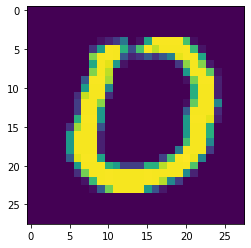

TRAIN_SIZE = 25200, BATCH_SIZE = 32, EPOCH = 8, TRAIN_STEPS = 787
epoch =  2, train cost = 4373.63, train accuracy = 0.950794, test cost = 1434.05, test accuracy = 0.95119
epoch =  4, train cost = 2569.11, train accuracy = 0.971389, test cost = 900.897, test accuracy = 0.966667
epoch =  6, train cost = 1729.22, train accuracy = 0.979048, test cost = 626.667, test accuracy = 0.977143
epoch =  8, train cost = 1208.02, train accuracy = 0.985556, test cost = 490.054, test accuracy = 0.980595
finally: validation cost = 552.378, validation accuracy = 0.980952


In [2]:
# tensorflow version 1.15
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

train_data_file = "~/datasets/digit-recognizer/train.csv"
kaggle_test_data_file = "~/datasets/digit-recognizer/test.csv"
kaggle_submit_file = "~/datasets/digit-recognizer/result.csv"

raw_dataset = pd.read_csv(train_data_file, sep=",").values
raw_kaggle_test_dataset = pd.read_csv(kaggle_test_data_file, sep=",").values

total_size = raw_dataset.shape[0]
split_point = [total_size * 6 // 10, total_size * 8 // 10]

raw_train_dataset = raw_dataset[: split_point[0]]
raw_validate_dataset = raw_dataset[split_point[0]: split_point[1]]
raw_test_dataset = raw_dataset[split_point[1]:]


def dense2one_hot(label_dense: np.ndarray, classes_count: int) -> np.ndarray:
    num_label = label_dense.shape[0]
    index_offset = np.arange(num_label) * classes_count
    label_one_hot = np.zeros(shape=[num_label, classes_count], dtype=np.int)
    label_one_hot.flat[index_offset + label_dense.ravel()] = 1
    return label_one_hot


def parse_dataset(dataset: np.ndarray) -> (np.ndarray, np.ndarray):
    label = dataset[:, : 1].astype(np.int)
    classes_count = np.unique(label).shape[0]
    return dataset[:, 1:].astype(np.float32).reshape(-1, 28, 28, 1) / 255.0, dense2one_hot(label, classes_count).astype(np.float32)


datasets = {
    "train": {},
    "validation": {},
    "test": {}
}

datasets["train"]["input"], datasets["train"]["label"] = parse_dataset(raw_train_dataset)
datasets["validation"]["input"], datasets["validation"]["label"] = parse_dataset(raw_validate_dataset)
datasets["test"]["input"], datasets["test"]["label"] = parse_dataset(raw_test_dataset)

for key in ["train", "validation", "test"]:
    print("{} -> input: {}, label: {}".format(key, datasets[key]["input"].shape, datasets[key]["label"].shape))


def plot_digit(pixels):
    plt.imshow(pixels.reshape(28, 28))
    plt.show()


plot_digit(datasets["test"]["input"][0, :])

session = tf.Session()

INPUT = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1])
LABEL = tf.placeholder(dtype=tf.float32, shape=[None, 10])

previous_output = INPUT

def create_network(num):
    global previous_output
    _weight = tf.get_variable("weight", shape=[5, 5, 1, num], dtype=tf.float32,
                                initializer=tf.truncated_normal_initializer(stddev=0.1))
    _bias = tf.get_variable("bias", shape=[num], dtype=tf.float32,
                            initializer=tf.constant_initializer(value=0.1))
    conv = tf.nn.conv2d(previous_output, _weight, strides=[1, 1, 1, 1], padding="SAME")
    active = tf.nn.relu(tf.add(conv, _bias))
    previous_output = tf.nn.max_pool(active, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

for i in range(2):
    with tf.variable_scope("conv_%d" % i):
        create_network(32 << i)

with tf.variable_scope("fc_0"):
    flatten = tf.reshape(previous_output, [-1, 7 * 7 * 64])
    weight = tf.get_variable("weight", shape=[7 * 7 * 64, 1024], dtype=tf.float32,
                                initializer=tf.truncated_normal_initializer(stddev=0.1))
    bias = tf.get_variable("bias", shape=[1024], dtype=tf.float32,
                            initializer=tf.constant_initializer(value=0.1))
    previous_output = tf.nn.relu(tf.add(tf.matmul(flatten, weight), bias))

# dropout
rate = tf.placeholder(dtype=tf.float32)
previous_output = tf.nn.dropout(previous_output, rate=rate)

with tf.variable_scope("fc_1"):
    weight = tf.get_variable("weight", shape=[1024, 10], dtype=tf.float32,
                                initializer=tf.truncated_normal_initializer(stddev=0.1))
    bias = tf.get_variable("bias", shape=[10], dtype=tf.float32, initializer=tf.constant_initializer(value=0.1))
    previous_output = tf.nn.softmax(tf.add(tf.matmul(previous_output, weight), bias))

cross_entropy = -tf.reduce_sum(LABEL * tf.log(previous_output))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(previous_output, 1), tf.argmax(LABEL, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

TRAIN_SIZE = datasets['train']['input'].shape[0]
BATCH_SIZE = 32
EPOCH = 8
TRAIN_STEPS = TRAIN_SIZE // BATCH_SIZE

print("TRAIN_SIZE = {}, BATCH_SIZE = {}, EPOCH = {}, TRAIN_STEPS = {}".
        format(TRAIN_SIZE, BATCH_SIZE, EPOCH, TRAIN_STEPS))

session.run(tf.global_variables_initializer())
session.graph.finalize()
summary_writer = tf.compat.v1.summary.FileWriter("./log/", session.graph)

for i in range(EPOCH):
    np.random.shuffle(raw_train_dataset)
    input_data, label_data = parse_dataset(raw_train_dataset)

    for j in range(TRAIN_STEPS):
        lower = j * BATCH_SIZE
        upper = (j + 1) * BATCH_SIZE
        batch_input = input_data[lower: upper]
        batch_label = label_data[lower: upper]

        session.run(train_step, {
            INPUT: batch_input,
            LABEL: batch_label,
            rate: 0.5
        })

    if (i + 1) % 2 == 0:
        train_acc, train_cost = session.run([accuracy, cross_entropy], {
            INPUT: input_data,
            LABEL: label_data,
            rate: 0.0
        })

        test_acc, test_cost = session.run([accuracy, cross_entropy], {
            INPUT: datasets["test"]["input"],
            LABEL: datasets["test"]["label"],
            rate: 0.0
        })
        print("epoch = %2d, train cost = %g, train accuracy = %g, test cost = %g, test accuracy = %g" % (
            i + 1, train_cost, train_acc, test_cost, test_acc))

validate_acc, validate_cost = session.run([accuracy, cross_entropy], {
    INPUT: datasets["validation"]["input"],
    LABEL: datasets["validation"]["label"],
    rate: 0.0
})

print("finally: validation cost = %g, validation accuracy = %g" % (validate_cost, validate_acc))


In [0]:
kaggle_test_dataset = raw_kaggle_test_dataset.astype(np.float32).reshape(-1, 28, 28, 1) / 255.0

prediction = session.run(previous_output, {
    INPUT: kaggle_test_dataset,
    rate: 0.0
})

In [0]:
label_test = np.argmax(prediction, axis=1)
result = pd.concat([pd.Series(range(1, label_test.shape[0] + 1), name="ImageId"), pd.Series(label_test, name="Label")], axis = 1)
result.head()
result.to_csv(kaggle_submit_file, index=False)